In [113]:
#import and file path setup
#for all the files
import os
import cv2

#for color Transform
import numpy as np

#for mainDISC
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
from PIL import Image
import glob
import imp

mainDir = r"C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy" #CHANGE FILE PATH
MovFile = 'IMG_2525.mov' #CHANGE FILE PATH

In [114]:
#video to frames
#change the path to where you put your video

inDir_VTF = mainDir
outDir_VTF = mainDir+"/OriFrames"

if not os.path.exists(outDir_VTF):
    os.makedirs(outDir_VTF)

vc = cv2.VideoCapture(inDir_VTF + '/'+MovFile) # change the name of the video file
c = 10

if vc.isOpened():
    rval, frame = vc.read()
else:
    rval = False
    
print(rval) # for checking if the file exists

timeF = 30 #number of actual frames between two captured frames

while rval:
    
    rval, frame = vc.read()
    if c%timeF == 0:
        cv2.imwrite(outDir_VTF + '/' + str(1100000+c) + r'.png', frame)
    c += 1
    cv2.waitKey(1)
vc.release()

# All the frames


# vidcap = cv2.VideoCapture('big_buck_bunny_720p_5mb.mp4')
# success,image = vidcap.read()
count = 0
while rval:
    rval, frame = vc.read()
    if rval:
        cv2.imwrite(outDir_VTF + '/Frames/'+'frame' + str(100000+count) +r'.jpg', frame)     # save frame as JPEG file      

        print('Read a new frame: ', count)
    count += 1
    cv2.waitKey(1)
print('done!')
vc.release()

True
done!


In [115]:
#Image Crop in Square

window_width = 800
window_height = 600


def draw_box(image):
    # Display the image and allow the user to draw a box
    clone = image.copy()
    cv2.namedWindow("Draw Box", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw Box", window_width, window_height)
    cv2.imshow("Draw Box", clone)

    # Initialize variables for the box coordinates
    box_start = None
    box_end = None
    drawing = False

    def draw_rectangle(event, x, y, flags, param):
        nonlocal box_start, box_end, drawing

        # Handle mouse events
        if event == cv2.EVENT_LBUTTONDOWN:
            box_start = (x, y)
            drawing = True

        elif event == cv2.EVENT_LBUTTONUP:
            box_end = (x, y)
            drawing = False

            # Draw the rectangle on the image
            cv2.rectangle(clone, box_start, box_end, (0, 255, 0), 2)
            cv2.imshow("Draw Box", clone)

    # Register the callback function for mouse events
    cv2.setMouseCallback("Draw Box", draw_rectangle)

    # Wait for the user to draw the box and close the window
    while True:
        key = cv2.waitKey(1) & 0xFF

        if key == ord("r"):
            # Reset the box if the 'r' key is pressed
            clone = image.copy()
            cv2.imshow("Draw Box", clone)

        elif key == ord("c"):
            # Close the window and proceed to crop the images if the 'c' key is pressed
            break

    cv2.destroyAllWindows()

    # Return the box coordinates
    return box_start, box_end


def crop_images(images, box_start, box_end):
    cropped_images = []

    # Crop each image based on the box coordinates
    for image in images:
        cropped_image = image[box_start[1]:box_end[1], box_start[0]:box_end[0]]

        # Create a mask with the same size as the cropped image
        mask = np.zeros(cropped_image.shape[:2], dtype=np.uint8)

        # Set the region outside the box to be transparent
        cv2.rectangle(mask, (0, 0), (cropped_image.shape[1], cropped_image.shape[0]), (255,), -1)

        # Set the cropped region to be opaque (non-transparent)
        cv2.rectangle(mask, (box_start[0], box_start[1]), (box_end[0], box_end[1]), (0,), -1)

        # Merge the cropped image with the transparent mask
        cropped_image = cv2.merge((cropped_image, mask[:, :, np.newaxis]))

        cropped_images.append(cropped_image)

    return cropped_images


# Directory containing the images
inDir_Crop = mainDir + "/OriFrames"
outDir_Crop = mainDir + "/CroppedRect"

if not os.path.exists(outDir_Crop):
    os.makedirs(outDir_Crop)

# Get a list of image file names in the directory
image_files = [f for f in os.listdir(inDir_Crop) if f.endswith('.png')]

# Load the images
images = [cv2.imread(os.path.join(inDir_Crop, image_file)) for image_file in image_files]

# Draw a box on the first image
box_start, box_end = draw_box(images[0])

# Crop the series of images
cropped_images = crop_images(images, box_start, box_end)

def returnZero(currentI, desiredNum):
    ans = ""
    for i in range(desiredNum - len(str(currentI))):
        ans += "0"
    return ans

# Save the cropped images
for i, cropped_image in enumerate(cropped_images):
    cv2.imwrite(os.path.join(outDir_Crop, returnZero(i + 1, len(str(len(cropped_images)))) + f"{i + 1}.png"), cropped_image)


In [116]:
#Image Crop in polygon

WINDOW_WIDTH, WINDOW_HEIGHT = 800, 600  # Define the fixed size for the editing window
points = []  # To store the points drawn on the first image
input_directory = mainDir + "/CroppedRect"
output_directory = mainDir+"/Cropped"

def crop_image(image, points, resize_factor):
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    points_np = np.array(points, dtype=np.int32)  # Convert points to a numpy array
    points_resized = (points_np * resize_factor).astype(np.int32)
    cv2.drawContours(mask, [points_resized], -1, 255, thickness=cv2.FILLED)

    # Crop the face region from the original image
    face = cv2.bitwise_and(image, image, mask=mask)

    # Create a new image with an alpha channel (4 channels)
    h, w = face.shape[:2]
    cropped_with_alpha = np.zeros((h, w, 4), dtype=np.uint8)
    cropped_with_alpha[:, :, :3] = face
    cropped_with_alpha[:, :, 3] = mask

    return cropped_with_alpha

def draw_outline(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
    elif event == cv2.EVENT_LBUTTONUP:
        cv2.circle(clone, (x, y), 2, (0, 0, 255), -1)
        if len(points) > 1:
            cv2.polylines(clone, np.array([points]), True, (0, 0, 255), 1)
        cv2.imshow("Image", clone)

def main():
    os.makedirs(output_directory, exist_ok=True)

    first_image = None

    for filename in os.listdir(input_directory):
        if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image_path = os.path.join(input_directory, filename)
            image = cv2.imread(image_path)

            if image is not None:
                if first_image is None:
                    first_image = image.copy()

                    global clone
                    clone = first_image.copy()

                    # Resize the image and clone to the fixed window size
                    height, width = clone.shape[:2]
                    resize_factor = min(WINDOW_WIDTH / width, WINDOW_HEIGHT / height)
                    clone = cv2.resize(clone, None, fx=resize_factor, fy=resize_factor)

                    cv2.namedWindow("Image", cv2.WINDOW_NORMAL)  # Allow window resizing
                    cv2.resizeWindow("Image", clone.shape[1], clone.shape[0])

                    cv2.setMouseCallback("Image", draw_outline)

                    print("Draw an outline on the image and press 'c' to crop or 'ESC' to skip.")

                    while True:
                        cv2.imshow("Image", clone)
                        key = cv2.waitKey(1) & 0xFF
                        if key == ord("r"):  # Press 'r' to reset the points
                            clone = cv2.resize(first_image.copy(), None, fx=resize_factor, fy=resize_factor)
                            points.clear()
                        elif key == ord("c"):  # Press 'c' to continue
                            if len(points) > 2:
                                cv2.destroyAllWindows()
                                break
                        elif key == 27:  # Press 'ESC' to skip
                            cv2.destroyAllWindows()
                            first_image = None
                            break

                if len(points) > 2:
                    cropped_image = crop_image(image, points, 1/resize_factor)
                    output_path = os.path.join(output_directory, filename)
                    cv2.imwrite(output_path, cropped_image)
                    print(f"{filename} cropped and saved successfully!")

if __name__ == "__main__":
    main()


Draw an outline on the image and press 'c' to crop or 'ESC' to skip.
01.png cropped and saved successfully!
02.png cropped and saved successfully!
03.png cropped and saved successfully!
04.png cropped and saved successfully!
05.png cropped and saved successfully!
06.png cropped and saved successfully!
07.png cropped and saved successfully!
08.png cropped and saved successfully!
09.png cropped and saved successfully!
10.png cropped and saved successfully!
11.png cropped and saved successfully!
12.png cropped and saved successfully!
13.png cropped and saved successfully!
14.png cropped and saved successfully!
15.png cropped and saved successfully!
16.png cropped and saved successfully!
17.png cropped and saved successfully!
18.png cropped and saved successfully!
19.png cropped and saved successfully!
20.png cropped and saved successfully!
21.png cropped and saved successfully!
22.png cropped and saved successfully!
23.png cropped and saved successfully!
24.png cropped and saved successfu

In [117]:
#Eye Blacks
import dlib

def detect_eyes(image_path: str):
    """
    Detect eyes in the provided image using Dlib's facial landmarks detector.

    Parameters:
    - image_path (str): Path to the input image.

    Returns:
    - Tuple of left_eye and right_eye coordinates to be blacked out.
    """

    # Load the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize Dlib's face detector and facial landmarks predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(r"C:\Users\ahj28\Desktop\Python\shape_predictor_68_face_landmarks.dat")  #CHANGE FILE PATH

    # Detect faces in the image
    faces = detector(gray)

    if len(faces) > 0:
        # Take the first detected face
        face = faces[0]

        # Predict facial landmarks
        landmarks = predictor(gray, face)

        # Use landmark points 36-41 for left eye and 42-47 for right eye, then adjust them
        left_eye = adjust_landmarks(np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]))
        right_eye = adjust_landmarks(np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]))

        return left_eye, right_eye

    # If no faces are detected, return None
    return None, None

def adjust_landmarks(landmarks, factor=1):
    # Compute the centroid
    centroid = np.mean(landmarks, axis=0)

    # Adjust each landmark
    adjusted = []
    for point in landmarks:
        extended_vector = point + (point - centroid) * factor
        adjusted.append(tuple(extended_vector.astype(np.int32)))
    return np.array(adjusted, dtype=np.int32)

# Folder paths
input_folder = mainDir + "/Cropped"
output_folder = mainDir + "/EyeBlacked"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process the first image to detect the region to be blacked out
first_image_path = os.path.join(input_folder, os.listdir(input_folder)[0])
left_eye_coords, right_eye_coords = detect_eyes(first_image_path)
print(left_eye_coords)
print(right_eye_coords)
if left_eye_coords is not None and right_eye_coords is not None:
    # Loop through the rest of the images and apply the same blacking out coordinates
    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            input_image_path = os.path.join(input_folder, filename)
            output_image_path = os.path.join(output_folder, filename)

            # Load the image using OpenCV, including the alpha channel if it exists
            image_with_alpha = cv2.imread(input_image_path, cv2.IMREAD_UNCHANGED)

            # Check if the image has an alpha channel (transparency)
            if image_with_alpha.shape[-1] == 4:
                # Create a blank alpha channel with the same size as the image, set to fully opaque (255)
                alpha_channel = np.ones((image_with_alpha.shape[0], image_with_alpha.shape[1]), dtype=np.uint8) * 255
                # Preserve the original alpha channel for non-eye regions
                alpha_channel[...] = image_with_alpha[:, :, 3]
            else:
                # Create a blank alpha channel if the image doesn't have transparency
                alpha_channel = np.ones((image_with_alpha.shape[0], image_with_alpha.shape[1]), dtype=np.uint8) * 255

            # Fill the polygons over the eyes contours with 0 (fully transparent) to make them transparent
            cv2.fillPoly(alpha_channel, [left_eye_coords], color=0)
            cv2.fillPoly(alpha_channel, [right_eye_coords], color=0)

            # Merge the RGB channels with the updated alpha channel to create the new BGRA image
            image_with_alpha = cv2.cvtColor(image_with_alpha, cv2.COLOR_BGR2BGRA)
            image_with_alpha[:, :, 3] = alpha_channel

            # Save the modified image with transparent eyes
            cv2.imwrite(output_image_path, image_with_alpha)

else: 
    print("HELLO NO EYES?")

[[ 66 427]
 [120 395]
 [190 389]
 [256 427]
 [190 443]
 [120 447]]
[[293 424]
 [359 384]
 [427 382]
 [489 410]
 [433 432]
 [365 434]]


In [118]:
#DISC Main
# ====== IMPORTING MODULES
# locate the pydic module
pydic = imp.load_source('pydic', r'C:\Users\ahj28\Desktop\Python\pydic_v0_1-shifu.py') #CHANGE FILE PATH

#  ====== RUN PYDIC TO COMPUTE DISPLACEMENT AND STRAIN FIELDS (STRUCTURED GRID)
correl_wind_size = (80,80) # was (80,80) the size in pixel of the correlation windows
correl_grid_size = (30,30) # was (50,50) the size in pixel of the interval (dx,dy) of the correlation grid

pp = mainDir + "/EyeBlacked"

for filename in glob.glob(pp+'/*.png'):
    sample_image_file=Image.open(filename)
    break;

dic_file = pp +'/result.dic'   # format: "xxx.dic"

#ketamine before [(140, 560), (706, 1249)]
#ketamine after [(213, 563), (762, 1240)]
# read image series and write a separated result file
pydic.init(pp+'/*.png', correl_wind_size, correl_grid_size, dic_file, area_of_intersest=[(0,0), (sample_image_file.width,sample_image_file.height)] , Ref_First = True)
#can do all, if the area of interest is not there, "all, none" and can create new
#def init(image_pattern, win_size_px, grid_size_px, result_file, area_of_intersest=None, Ref_First = False, *args, **kwargs)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
# and read the result file for computing strain and displacement field from the result file


Preset Area: [(0, 0), (583, 806)]
[(0, 0), (583, 806)]
reading image 1 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\02.png"
reading image 2 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\03.png"
reading image 3 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\04.png"
reading image 4 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\05.png"
reading image 5 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\06.png"
reading image 6 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\07.png"
reading image 7 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\08.png"
reading image 8 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\09.png"
reading image 9 / 72 : "C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\10.png"
reading image 10 / 72 : "C:\Users\ahj28\Deskt


compute displacement and strain field of C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\01.png ...
interpolate displacement with raw method
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/disp/01_disp.png file...
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/vmap/01_vmap.png file...
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/result/01_result.csv file...

compute displacement and strain field of C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\02.png ...
interpolate displacement with raw method
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/disp/02_disp.png file...
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/vmap/02_vmap.png file...
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/result/02_result.csv file...

compute displacement and strain

C:\Users\ahj28\Desktop\Python\pydic_v0_1-shifu.py:1025: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure()


saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\22.png
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/overlaid/22_overlaid.png file...
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\23.png
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/overlaid/23_overlaid.png file...
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\24.png
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/overlaid/24_overlaid.png file...
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\25.png
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/overlaid/25_overlaid.png file...
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked\26.png
saving C:\Users\ahj28\Desktop\Garcia DISC Data\Controls\3\Happy/EyeBlacked/pydic/overlaid/26_overlaid.png file...
saving C:\Users\ahj2

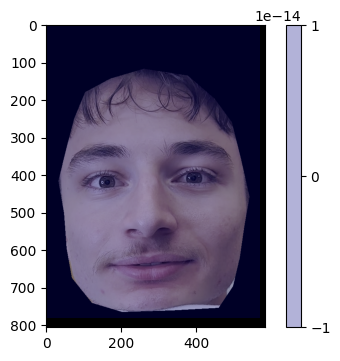

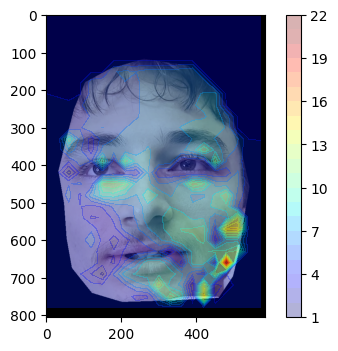

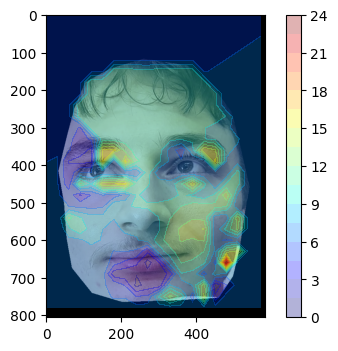

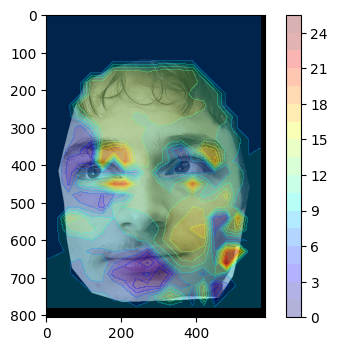

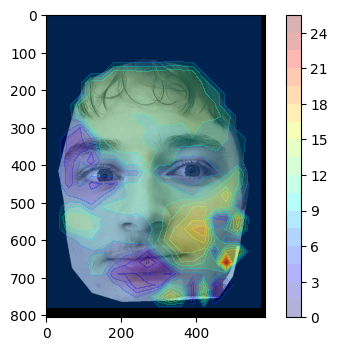

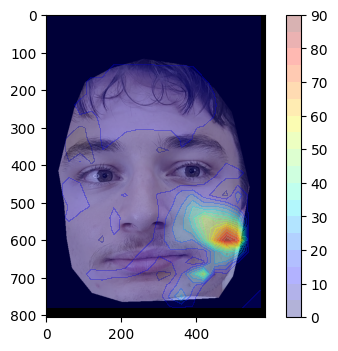

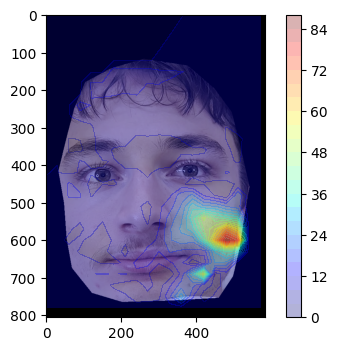

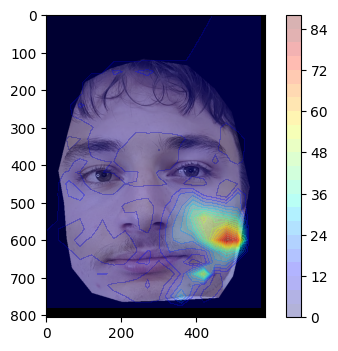

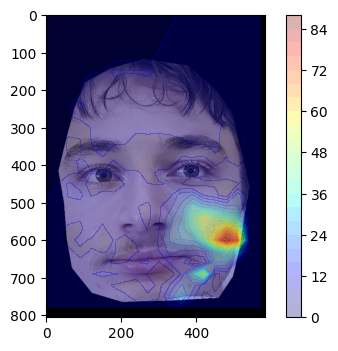

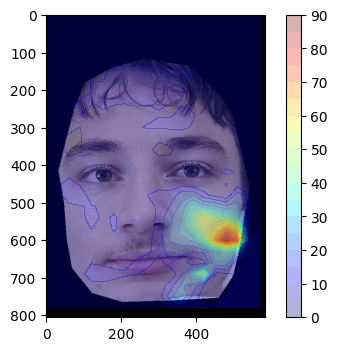

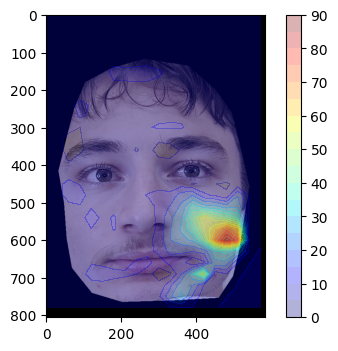

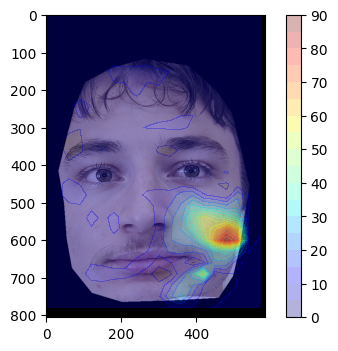

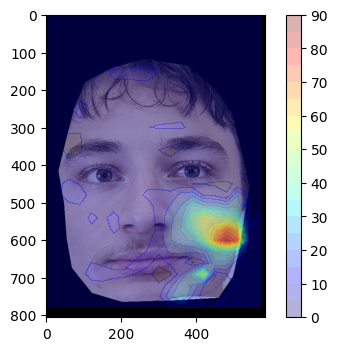

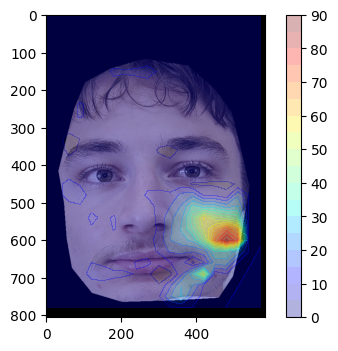

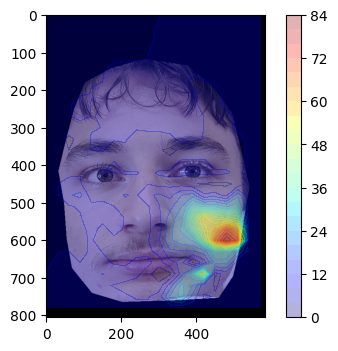

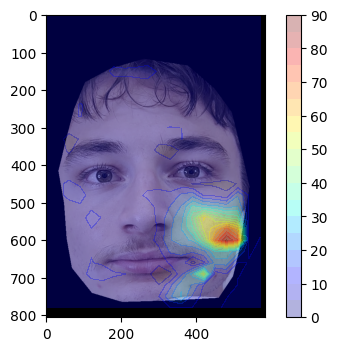

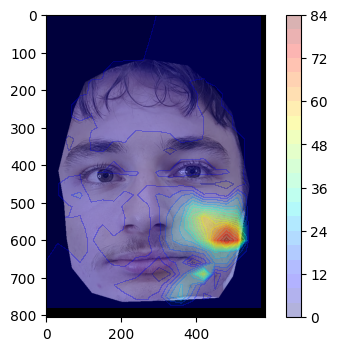

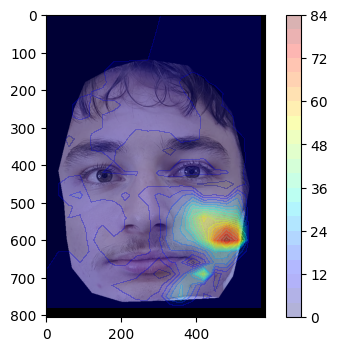

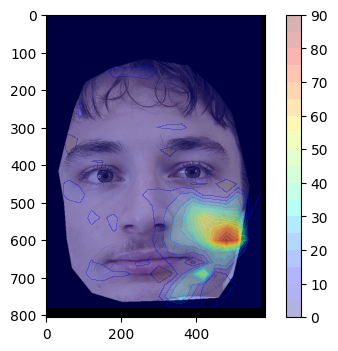

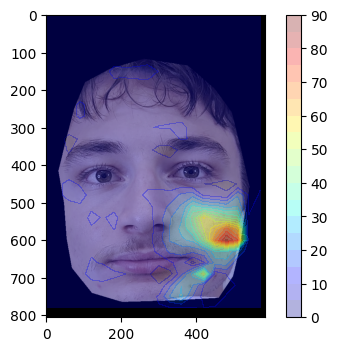

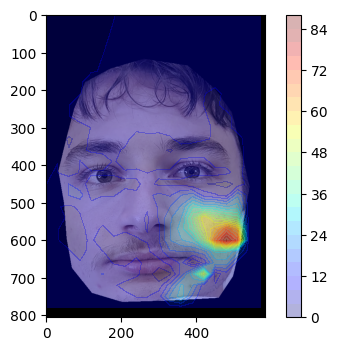

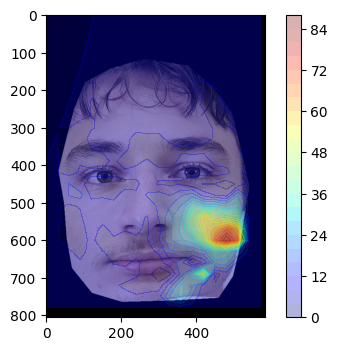

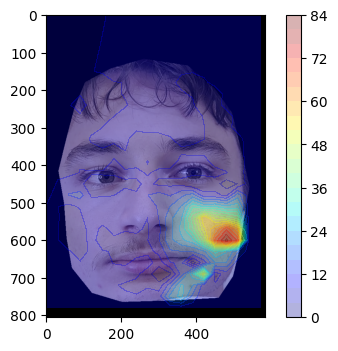

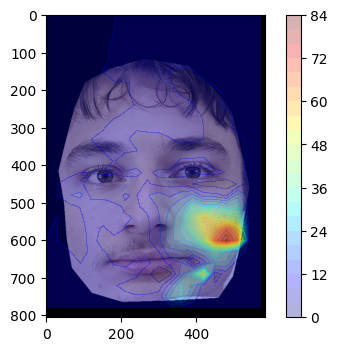

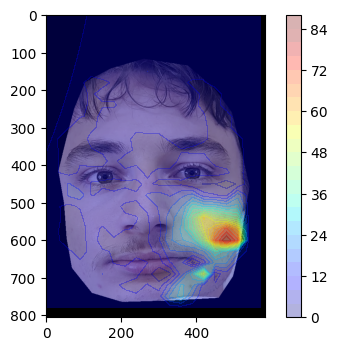

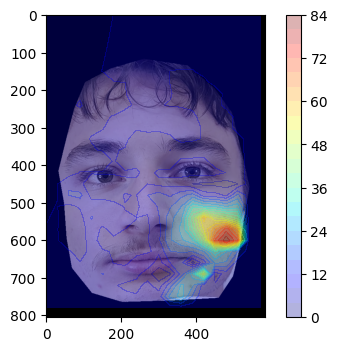

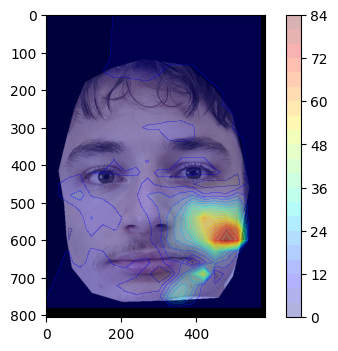

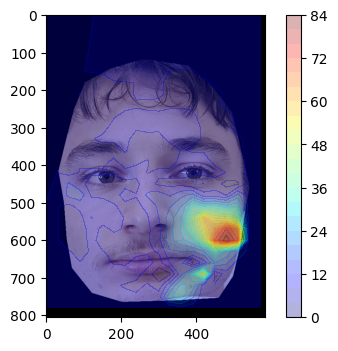

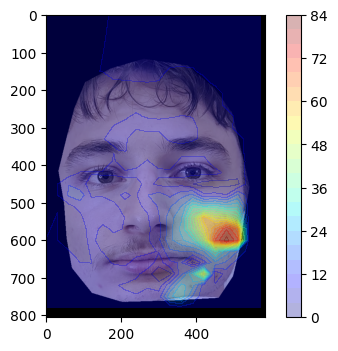

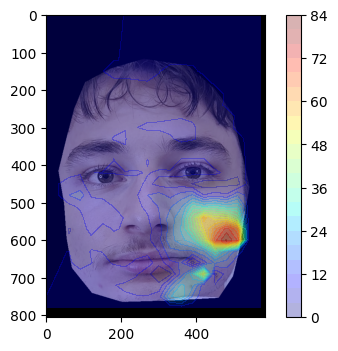

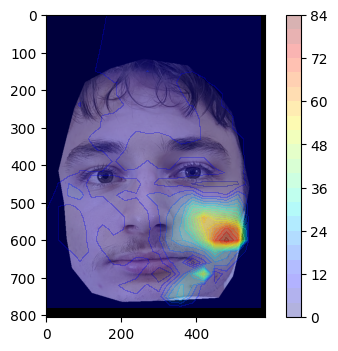

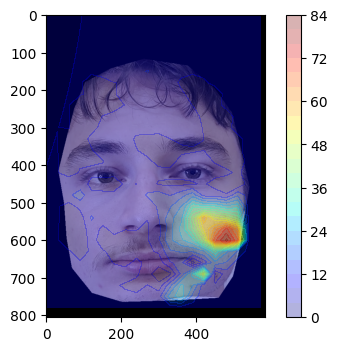

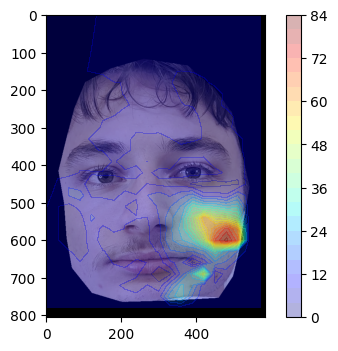

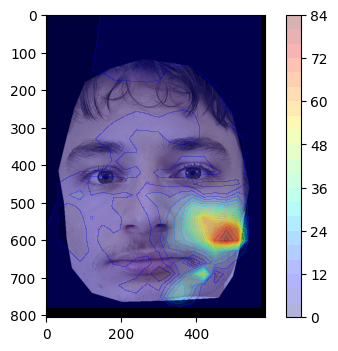

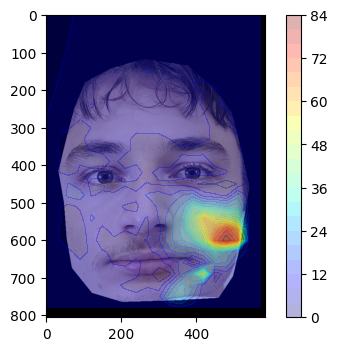

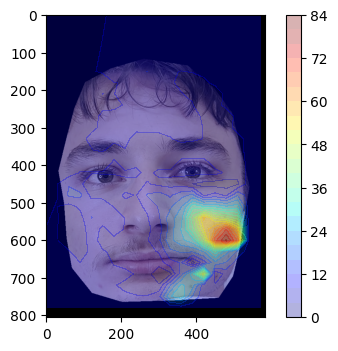

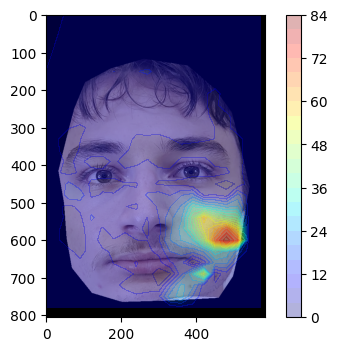

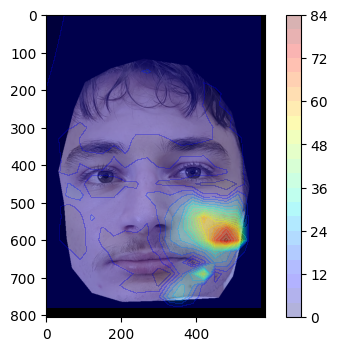

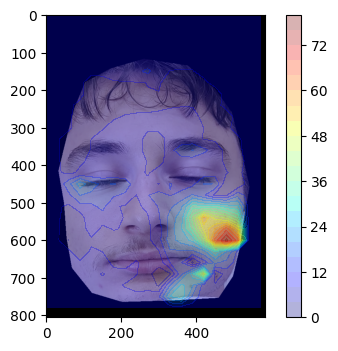

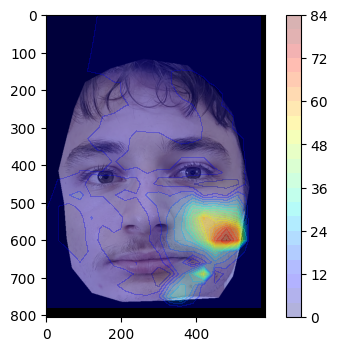

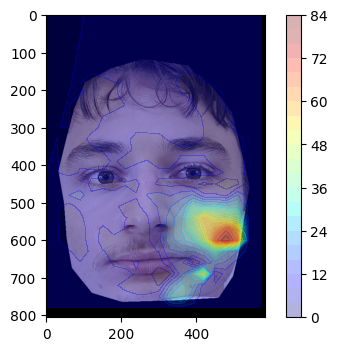

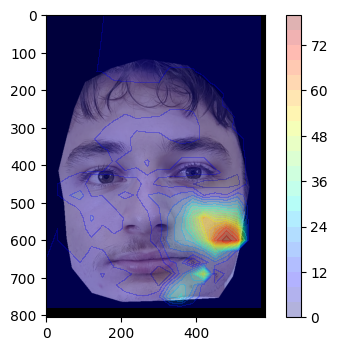

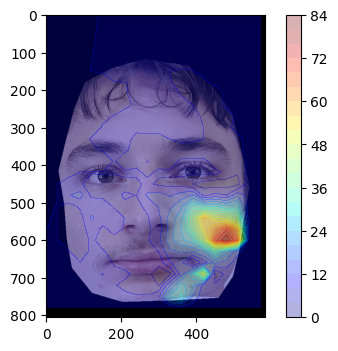

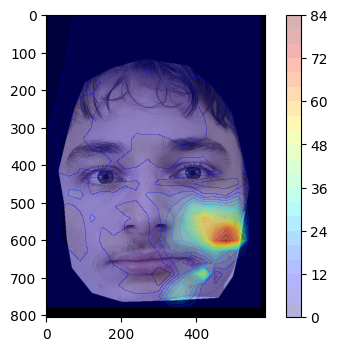

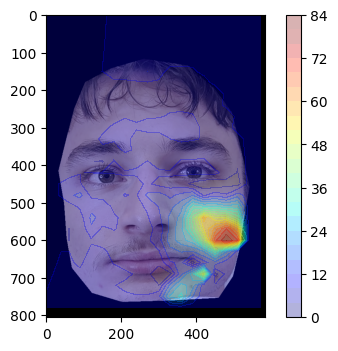

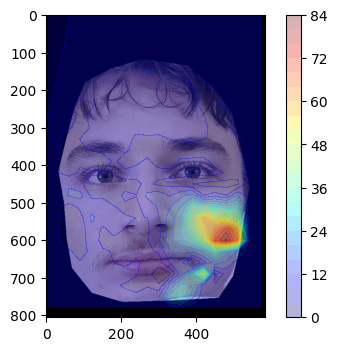

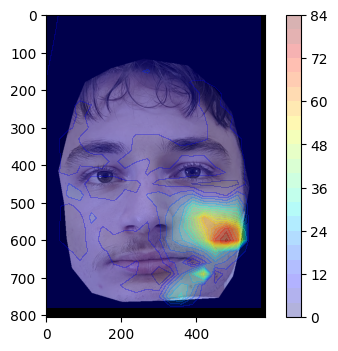

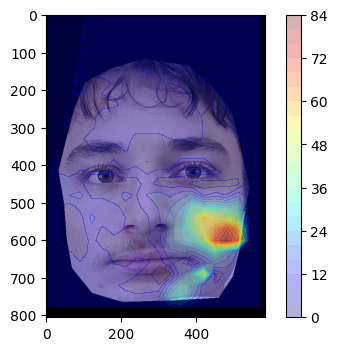

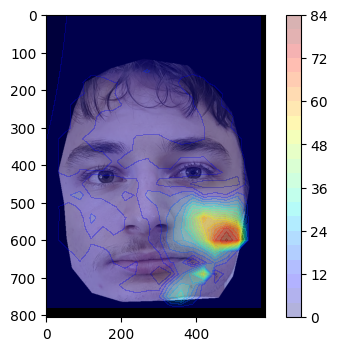

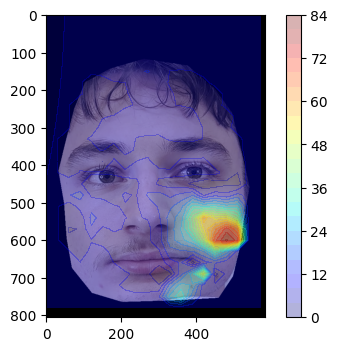

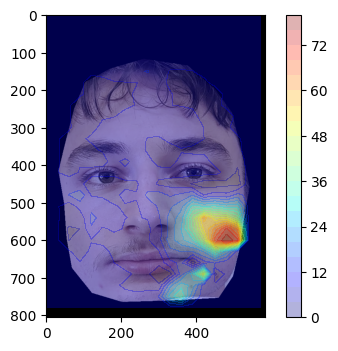

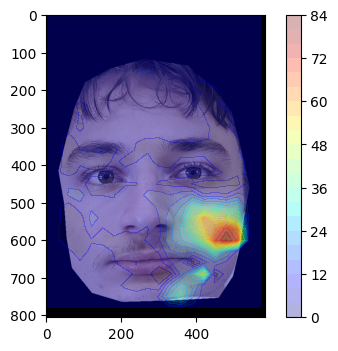

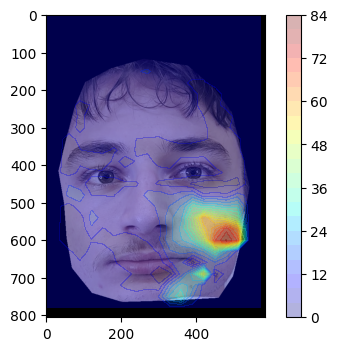

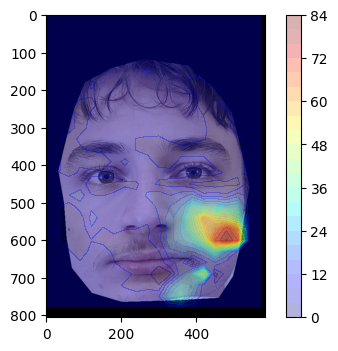

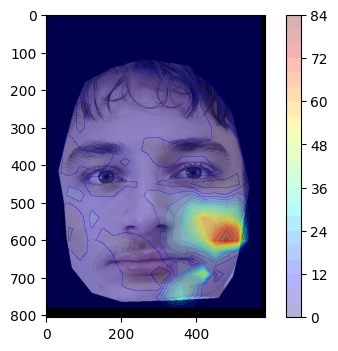

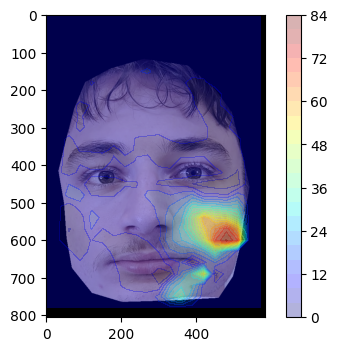

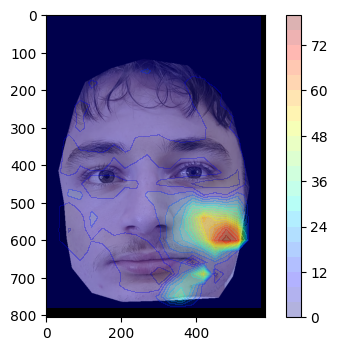

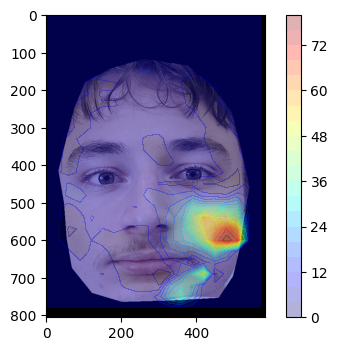

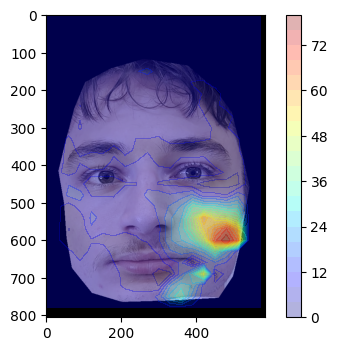

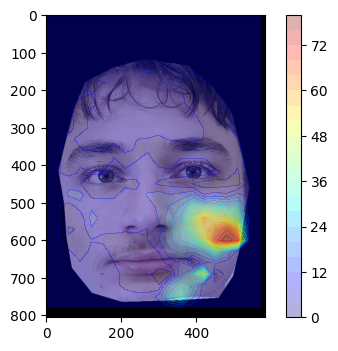

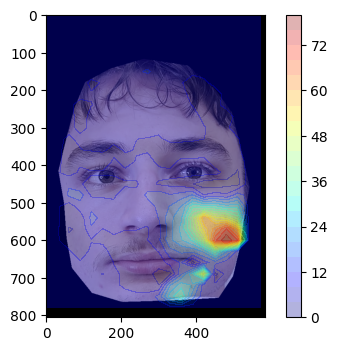

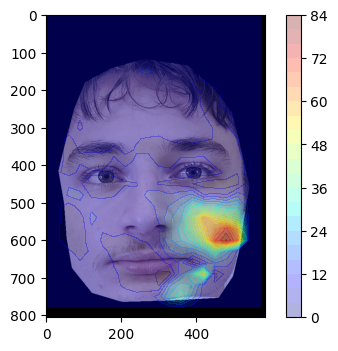

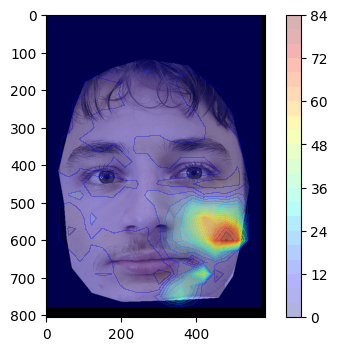

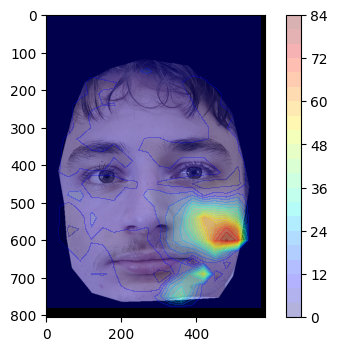

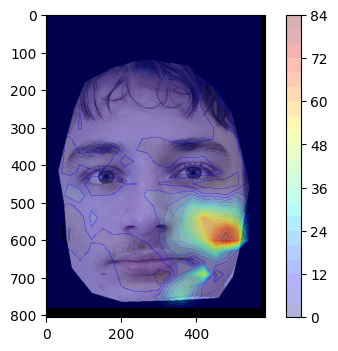

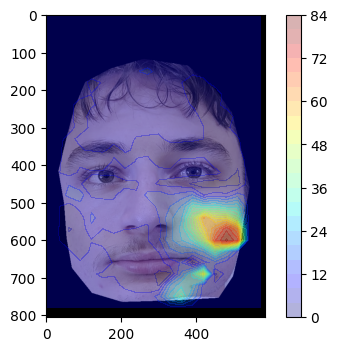

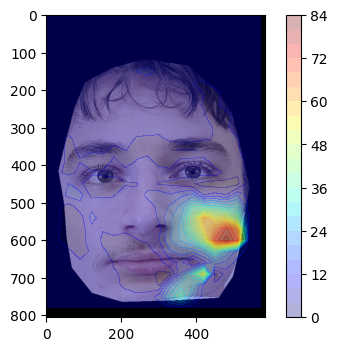

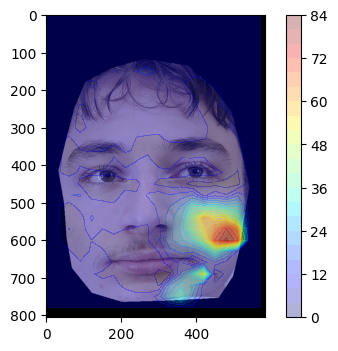

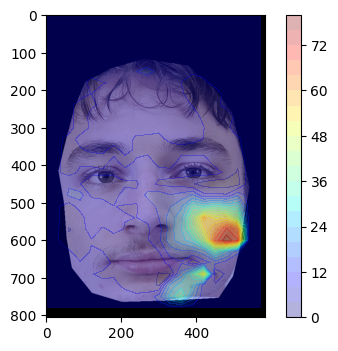

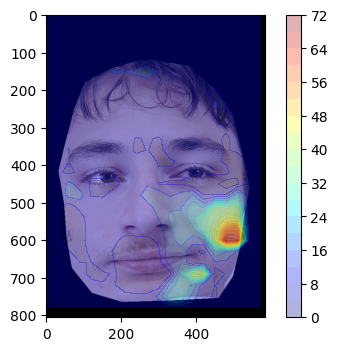

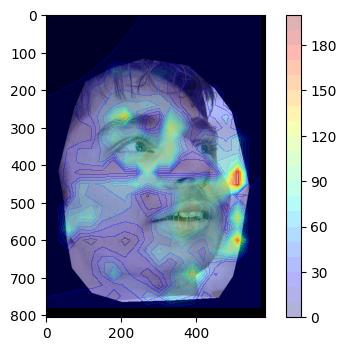

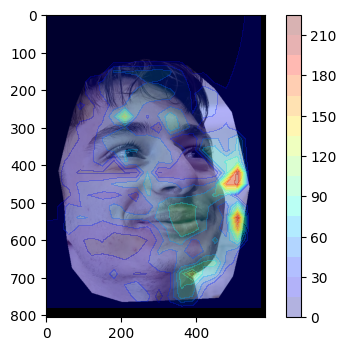

In [119]:
#Main DISC - 2
pydic.FixedscaleValues = [30,30,0]
#30 top range of movement and detection
pydic.read_dic_file(dic_file, FixedScale = False, interpolation='raw', save_image=True, scale_disp=1, scale_grid=1)
#Fixed Scale is about backgroud. When True